In [1]:
%matplotlib inline
from helpers import *

In [2]:
dfs = {} # global data structure with parsed data
parse(dfs, "4 Node, 100K", "../results/scale-workers-4-71541")
parse(dfs, "4 Node, 1M",   "../results/scale-workers-1M-4-71537")
df = clean_df(dfs, ("4 Node, 1M", "DBMemoryGet", "4"))

... parsed: scale-workers-4-71541 ... parsed: scale-workers-1M-4-71537


## K-Means
First find *K*, the number of clusters in the data using the sum of the distances to the centroid. Then apply K-Means and color clusters.

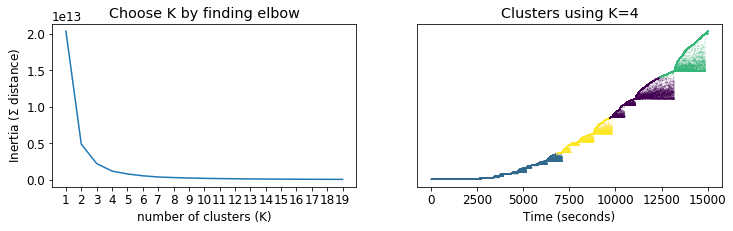

In [3]:
from sklearn.cluster import KMeans
fig, ax = plt.subplots(1, 2, figsize=(12, 3))

f1 = df['shift'].astype(int)      # feature 1 is the shifted timestamp (x-axis)
f2 = df['id'].astype(int)         # feature 2 is the key id (y-axis)
X  = np.matrix(zip(f1, f2))       # weight features equally

inertia = []                      # Graph 0: find optimal K using inertia as a metric
for n in range(1, 20):
    k = KMeans(n_clusters=n).fit(X)
    inertia.append(k.inertia_)
ax[0].plot(range(1, len(inertia)+1), inertia) 
ax[0].set_title("Choose K by finding elbow");
ax[0].set_xticks(range(1, len(inertia)+1));
ax[0].set_xlabel("number of clusters (K)")
ax[0].set_ylabel(r'Inertia ($\Sigma$ distance)')

k = KMeans(n_clusters=4).fit(X)   # Graph 1: run kmeans using K from graph 0
ax[1].scatter(df['shift'], df['id'], c=k.labels_, s=0.005)
ax[1].set_title("Clusters using K=4")
ax[1].set_xlabel("Time (seconds)")
ax[1].set_yticks([])
_ = ax[0].set_ylabel(r'Inertia ($\Sigma$ distance)')

## Offline

In [42]:
# Get the lowest value that comes after each index
X = np.squeeze(np.asarray(X))
lowestAfter = [0]*len(X) # List of (value, index)
lowestSeen = (X[-1][1], len(X)-1)
for i in range(len(X)-1, -1, -1):
    if X[i][-1] < lowestSeen[0]:
        lowestSeen = (X[i][1], i)    
    lowestAfter[i] = lowestSeen


In [43]:
# Get the highest value that has been seen before each index
### DEPRECATED, not necessary
highestBefore = [0]*len(X) # List of (value, index)
highestSeen = (X[0][1], 0)
for i in range(0, len(X)):
    if X[i][1] > highestSeen[0]:
        highestSeen = (X[i][1], i)
    highestBefore[i] = highestSeen

In [63]:
lowestAfterRanges = []
start = 0
for i in range(1, len(lowestAfter)):
    if lowestAfter[i] != lowestAfter[i-1]:
        lowestAfterRanges += [(start, i-1)]
        start = i
lowestAfterRanges += [(start, len(lowestAfter)-1)]

In [69]:
# Stitch together lowestAfterRanges using min/max values inside them
rangeMaxVals = []
for (start, end) in lowestAfterRanges:
    maxVal = max([X[i][1] for i in xrange(start, end+1)])
    rangeMaxVals += [maxVal]

stitchedRanges = []
curRange = (lowestAfterRanges[0], rangeMaxVals[0])
for i in range(1, len(lowestAfterRanges)):
    if X[lowestAfterRanges[i][1]][1] < curRange[1]:
        curRange = ((curRange[0][0], lowestAfterRanges[i][1]), max(curRange[1], rangeMaxVals[i]))
    else:
        stitchedRanges += [curRange[0]]
        curRange = (lowestAfterRanges[i], rangeMaxVals[i])

In [45]:
# DEPRECATED, not necessary
#highestBeforeRanges = []
#start = 0
#for i in range(1, len(highestBefore)):
#    if highestBefore[i] != highestBefore[i-1]:
#        highestBeforeRanges += [(start, i-1)]
#        start = i
#highestBeforeRanges += [(start, len(highestBefore)-1)]

In [70]:
# Get starts
stitchedStarts = set([i[0] for i in stitchedRanges])

In [71]:
import random
labels = [0]*len(X)
colors = range(len(stitchedStarts)+3)
color = random.choice(colors)
colors.remove(color)
for i in range(len(X)):
    if i in stitchedStarts:
        color = random.choice(colors)
        colors.remove(color)
    labels[i] = color

[]

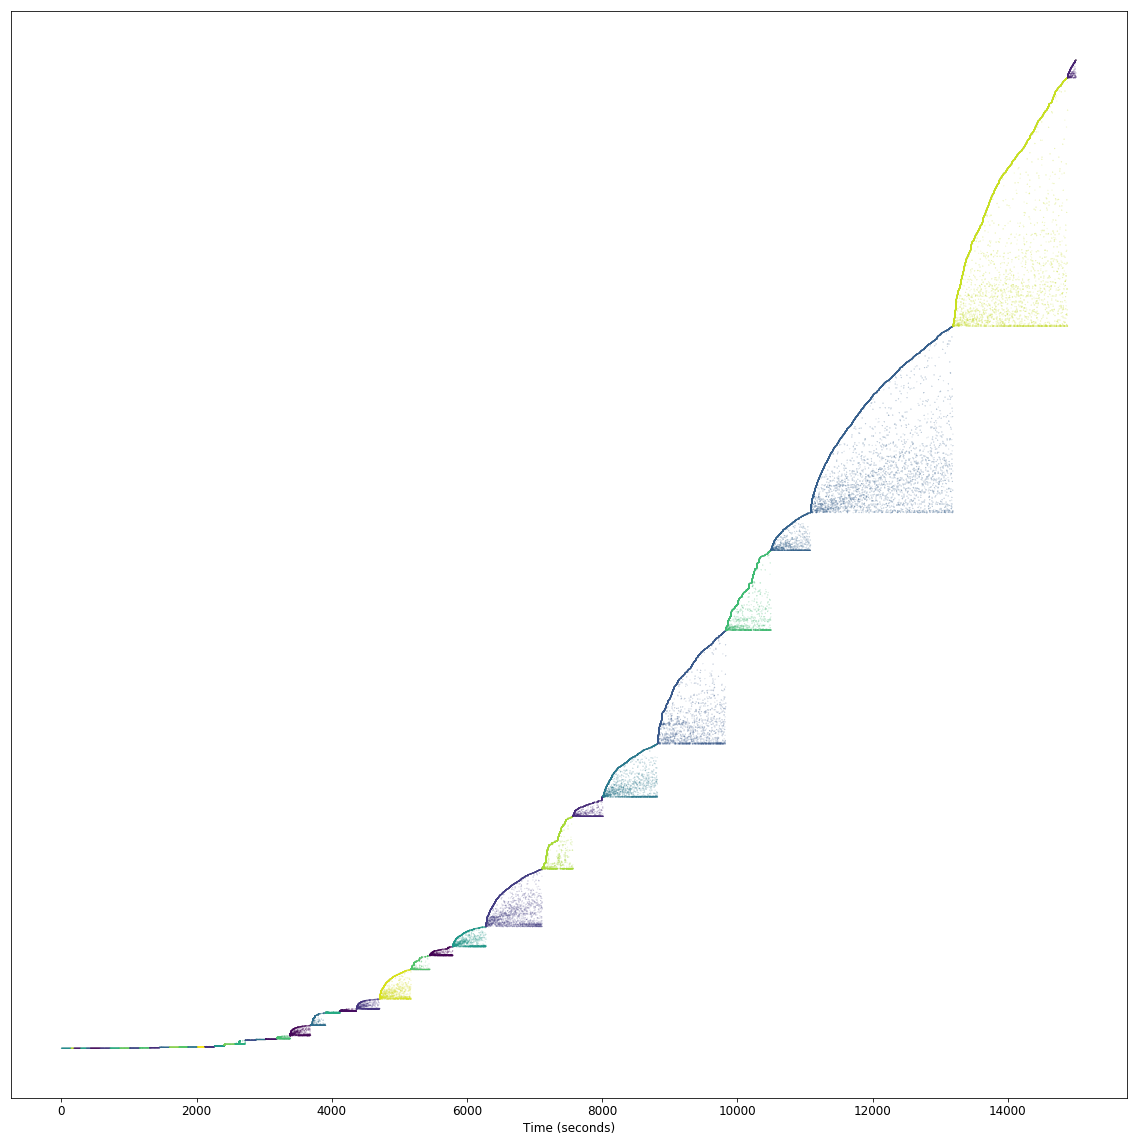

In [72]:
fig, ax = plt.subplots(1, 1, figsize=(20,20))
ax.scatter(df['shift'], df['id'], c=labels, s=0.005)
ax.set_xlabel("Time (seconds)")
ax.set_yticks([])

## Online

In [107]:
# Walking forward: if this is the current maximum, then it could be a new fan. If not, need to fold fans backwards appropriately.
sizeThreshold=6
forwardLabels = []
fans = [] # List of (fanID, min, max, size) tuples
currId = 0
currMax = -1
logs = []
for i in range(len(X)):
    y = X[i][1]
    if y > currMax:  # Biggest we've seen so far
        currMax = y
        currId = random.choice(xrange(10000))
        newFan = (currId, y, y, 1)
        fans += [newFan]
    else:      # Needs to be folded into previous fan, and perhaps even farther back
        while y < fans[-1][1] and len(fans) > 1:
            fans = fans[:-2] + [(fans[-2][0], fans[-2][1], fans[-1][2], fans[-2][3] + fans[-1][3])]
            currId = fans[-1][0]
        fans[-1] = (fans[-1][0], fans[-1][1], fans[-1][2], fans[-1][3]+1)
    labeled = False
    for i in range(len(fans)-1, -1, -1):
        if fans[i][3] >= sizeThreshold:
            forwardLabels += [fans[i][0]]
            labeled = True
            break
    if not labeled:
        forwardLabels += [currId]


[]

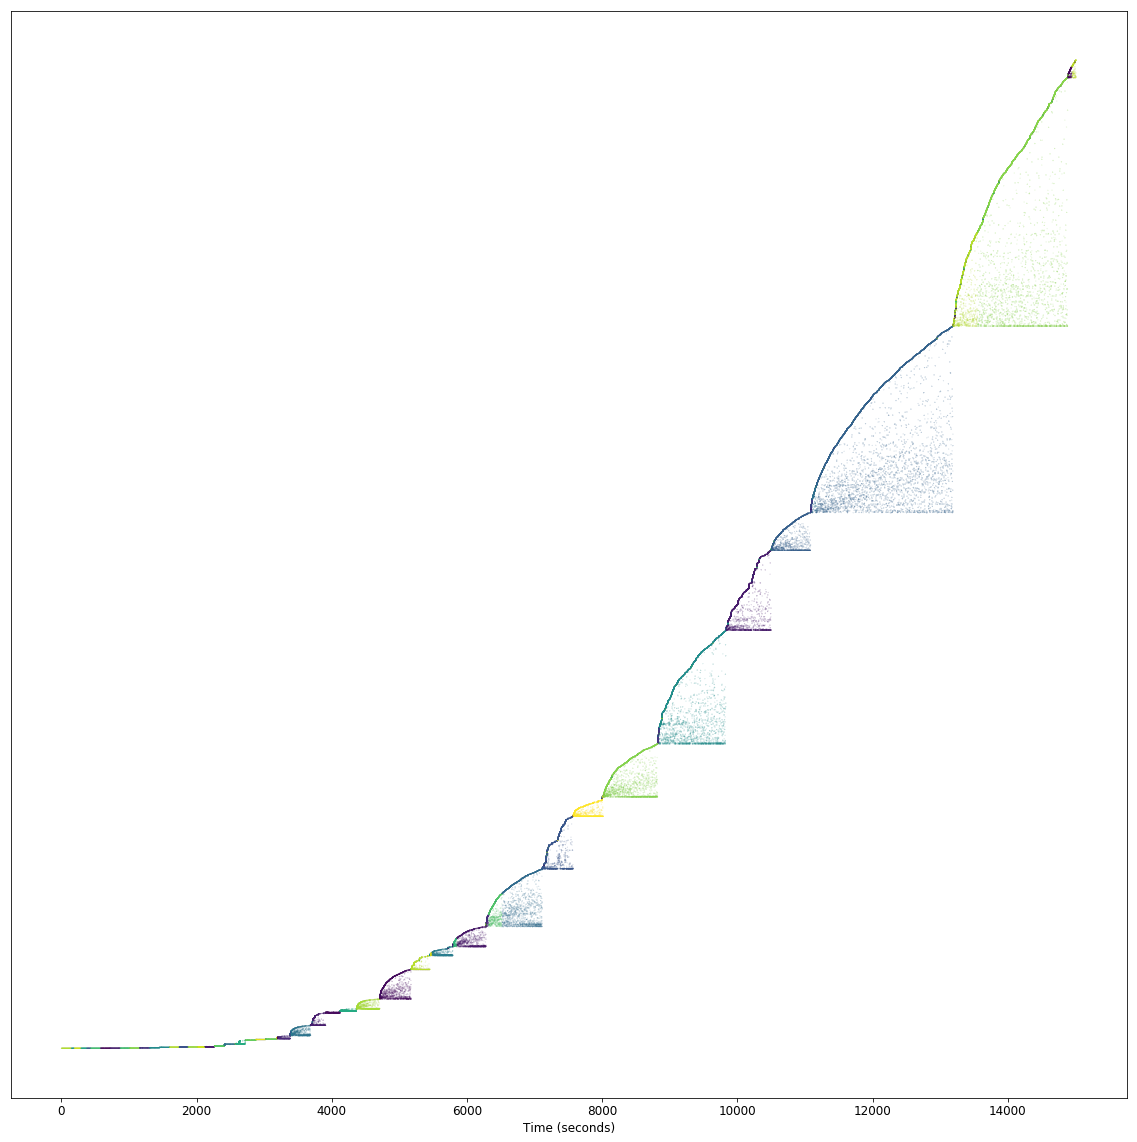

In [108]:
fig, ax = plt.subplots(1, 1, figsize=(20,20))
ax.scatter(df['shift'], df['id'], c=forwardLabels, s=0.005)
ax.set_xlabel("Time (seconds)")
ax.set_yticks([])

In [109]:
fans

[(8788, 1, 1, 144),
 (5311, 2, 2, 44),
 (9246, 3, 3, 100),
 (5920, 4, 4, 87),
 (2853, 5, 5, 59),
 (6931, 6, 6, 145),
 (9394, 7, 7, 1),
 (150, 8, 8, 146),
 (881, 9, 11, 150),
 (6962, 12, 15, 160),
 (8173, 16, 22, 174),
 (1552, 23, 35, 175),
 (4798, 36, 48, 189),
 (1314, 49, 49, 1),
 (3734, 50, 50, 1),
 (4795, 51, 60, 160),
 (7798, 61, 61, 2),
 (4913, 62, 62, 1),
 (8870, 63, 67, 148),
 (2526, 68, 70, 260),
 (9040, 71, 71, 1),
 (8495, 72, 75, 166),
 (9220, 76, 81, 220),
 (979, 82, 82, 1),
 (742, 83, 100, 307),
 (791, 101, 101, 1),
 (7452, 102, 149, 534),
 (4798, 150, 150, 1),
 (3797, 151, 232, 284),
 (6108, 233, 414, 533),
 (7639, 415, 452, 246),
 (1204, 453, 453, 1),
 (1148, 454, 454, 1),
 (9578, 455, 463, 212),
 (7711, 464, 498, 274),
 (3593, 499, 499, 2),
 (1109, 500, 639, 742),
 (858, 640, 640, 1),
 (3839, 641, 1181, 1446),
 (804, 1182, 1823, 1132),
 (1709, 1824, 1824, 2),
 (275, 1825, 1900, 602),
 (6055, 1901, 2018, 833),
 (6973, 2019, 2019, 1),
 (8660, 2020, 2528, 1551),
 (4195, 252

In [113]:
sum([x[3] for x in fans])

84068

In [112]:
X[16600:16700]

array([[5773, 4760],
       [5774, 4760],
       [5774, 4785],
       [5774, 4756],
       [5775, 4756],
       [5775, 5207],
       [5775, 5208],
       [5775, 4766],
       [5776, 4766],
       [5776, 4773],
       [5776, 4776],
       [5777, 4776],
       [5777, 4785],
       [5777, 4760],
       [5777, 5209],
       [5778, 4760],
       [5778, 4791],
       [5778, 4756],
       [5779, 4756],
       [5779, 5209],
       [5779, 5210],
       [5779, 4762],
       [5779, 5211],
       [5780, 4762],
       [5780, 4799],
       [5780, 4785],
       [5781, 4785],
       [5781, 4789],
       [5781, 4798],
       [5781, 4779],
       [5782, 4779],
       [5782, 5202],
       [5782, 4760],
       [5783, 4760],
       [5783, 4785],
       [5783, 4773],
       [5784, 4773],
       [5784, 5212],
       [5784, 4776],
       [5784, 4756],
       [5785, 4756],
       [5785, 4760],
       [5785, 4969],
       [5786, 4969],
       [5786, 5212],
       [5786, 5213],
       [5786, 5016],
       [5787,